In [1]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

# For single station training

In [ ]:
experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'Kho_loss_on_profile'

for station_id in ['PROF_OWEG','PROF_REDH','PROF_QUEE','PROF_BRON','PROF_STAT']:
    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc').Chebyshev_Coefficients
    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc').Chebyshev_Coefficients
    
    years = np.arange(2018, 2021)
    # Loop over each year and plot histograms
    for i, year in enumerate(years):
        for Ens in range(10):
            fig = plt.figure(figsize=(15, 12), constrained_layout=True)
            gs = fig.add_gridspec(4,5)
            #fig.suptitle(f'Histogram of Chebyshev Coefficients for {station_id}', fontsize=16)
            profiler_data = profiler_ds.sel(time=profiler_ds.time.dt.year == year).where(profiler_ds.outlier == 1, drop=True)
            NOW23_data = NOW23_ds.sel(time=profiler_data.time.values)
            row = 0
            for coeff in range(5):
                col = coeff
                ylabel = f'NOW23 Chebyshev coefficient' if col == 0 else ''
                xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
                title = f'Coefficient: C{coeff}' if row == 0 else ''
                hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                            NOW23_data.sel(coeff=coeff),
                            title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
            
            # ===   TabNet inputs   ===
            input_file = 'data/ERA5.nc'
            input_variables = [
                "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
                "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "cbh", "ishf", 
                "ie", "tcc", "lcc", "cape", "cin", "bld", "t_975", "t_950", "2mtempgrad", 
                "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
                "cosHR", "sinJDAY", "cosJDAY"
            ]
            input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
            Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'
            target_variables = [0,1,2,3,4]
            test_dates_range = (f'{year}-01-01T00:00:00', f'{year}-12-31T23:00:00')
            if segregated == 'segregated':
                segregate_arg = True
            else:
                segregate_arg = None
            X_test, Y_test = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
            print(profiler_data.shape, NOW23_data.shape,X_test.shape, Y_test.shape)

            # --- loading the model with only 2021 year training ---#
            row = 1
            model_output_dir = f'trained_models/{experiment}/{station_id}/{hourly_data_method}/2021/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
            fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
            with open(fSTR, "rb") as f:
                tabReg = pickle.load(f)
            
            Y_pred = tabReg.predict(X_test)
        
            if transformed == 'transformed':
                min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
                Y_pred = min_max_scaler.inverse_transform(Y_pred)

            for coeff in range(5):
                col = coeff
                ylabel = f'ML trained on 2021\n Chebyshev coefficient' if col == 0 else ''
                xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
                title = f'Coefficient: C{coeff}' if row == 0 else ''
                hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                            Y_pred[:,coeff],
                            title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
            
            # --- loading the model with only 2021 and 2022 years training ---#
            row = 2
            model_output_dir = f'trained_models/{experiment}/{station_id}/{hourly_data_method}/2021_to_2022/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
            fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
            with open(fSTR, "rb") as f:
                tabReg = pickle.load(f)
            
            Y_pred = tabReg.predict(X_test)
        
            if transformed == 'transformed':
                min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
                Y_pred = min_max_scaler.inverse_transform(Y_pred)

            for coeff in range(5):
                col = coeff
                ylabel = f'ML trained on 2021-2022\n Chebyshev coefficient' if col == 0 else ''
                xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
                title = f'Coefficient: C{coeff}' if row == 0 else ''
                hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                            Y_pred[:,coeff],
                            title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
            
            # --- loading the model with only 2021, 2022, and 2023 years training ---#
            row = 3
            model_output_dir = f'trained_models/{experiment}/{station_id}/{hourly_data_method}/2021_to_2023/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
            fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
            with open(fSTR, "rb") as f:
                tabReg = pickle.load(f)
            
            Y_pred = tabReg.predict(X_test)
        
            if transformed == 'transformed':
                min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
                Y_pred = min_max_scaler.inverse_transform(Y_pred)

            for coeff in range(5):
                col = coeff
                ylabel = f'ML trained on 2021-2023\n Chebyshev coefficient' if col == 0 else ''
                xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
                title = f'Coefficient: C{coeff}' if row == 0 else ''
                hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                            Y_pred[:,coeff],
                            title,text_arg=True, xlabel=xlabel, ylabel=ylabel)
            
            # save the figure
            fig.suptitle(f'{station_id} Chebyshev Coefficients for {year}, ML ensemble {Ens}', fontsize=16)
            plt.savefig(f'data/Figures/Comparison_bw_profiler_NOW23_ML_{station_id}_{year}_ML_ensemble_{Ens}.png')

# For multistation training

In [2]:
# === Input parameters ===
input_file = 'data/ERA5.nc'
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY"
]
input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
target_variables = [0,1,2,3,4]

experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'MSE_loss'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

test_station_ids = ['PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

X_test_all, Y_test_all = [], []
profiler_data_all, NOW23_data_all = [], []
for station_id in test_station_ids:
    Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'

    if segregated == 'segregated':
        segregate_arg = True
    else:
        segregate_arg = None
    X_test, Y_test, time_coord = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
    print(X_test.shape, Y_test.shape)
    # Collect testing data for all stations
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

    # profiler and NOW23 data
    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc').Chebyshev_Coefficients
    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc').Chebyshev_Coefficients

    profiler_data = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
    profiler_data = profiler_data.sel(time=time_coord)
    NOW23_data = NOW23_ds.sel(time=time_coord)
    profiler_data_all.append(profiler_data)
    NOW23_data_all.append(NOW23_data)
    
   
if len(test_station_ids) > 1:
    X_test = np.concatenate(X_test_all, axis=0)
    Y_test = np.concatenate(Y_test_all, axis=0)
    profiler_data = xr.concat(profiler_data_all, dim='time')
    NOW23_data = xr.concat(NOW23_data_all, dim='time')
else:
    X_test = X_test_all[0]
    Y_test = Y_test_all[0]
    profiler_data = profiler_data_all[0]
    NOW23_data = NOW23_data_all[0]

print(X_test.shape, Y_test.shape, profiler_data.shape, NOW23_data.shape)



Segregated times: 11902
Intersected times: 11629
(11629, 32) (11629, 5)
Segregated times: 16272
Intersected times: 15829
(15829, 32) (15829, 5)
Segregated times: 14682
Intersected times: 14393
(14393, 32) (14393, 5)
Segregated times: 12523
Intersected times: 12217
(12217, 32) (12217, 5)
Segregated times: 16161
Intersected times: 15833
(15833, 32) (15833, 5)
Segregated times: 5518
Intersected times: 5347
(5347, 32) (5347, 5)
Segregated times: 10762
Intersected times: 10429
(10429, 32) (10429, 5)
Segregated times: 8156
Intersected times: 8110
(8110, 32) (8110, 5)
Segregated times: 10492
Intersected times: 10492
(10492, 32) (10492, 5)


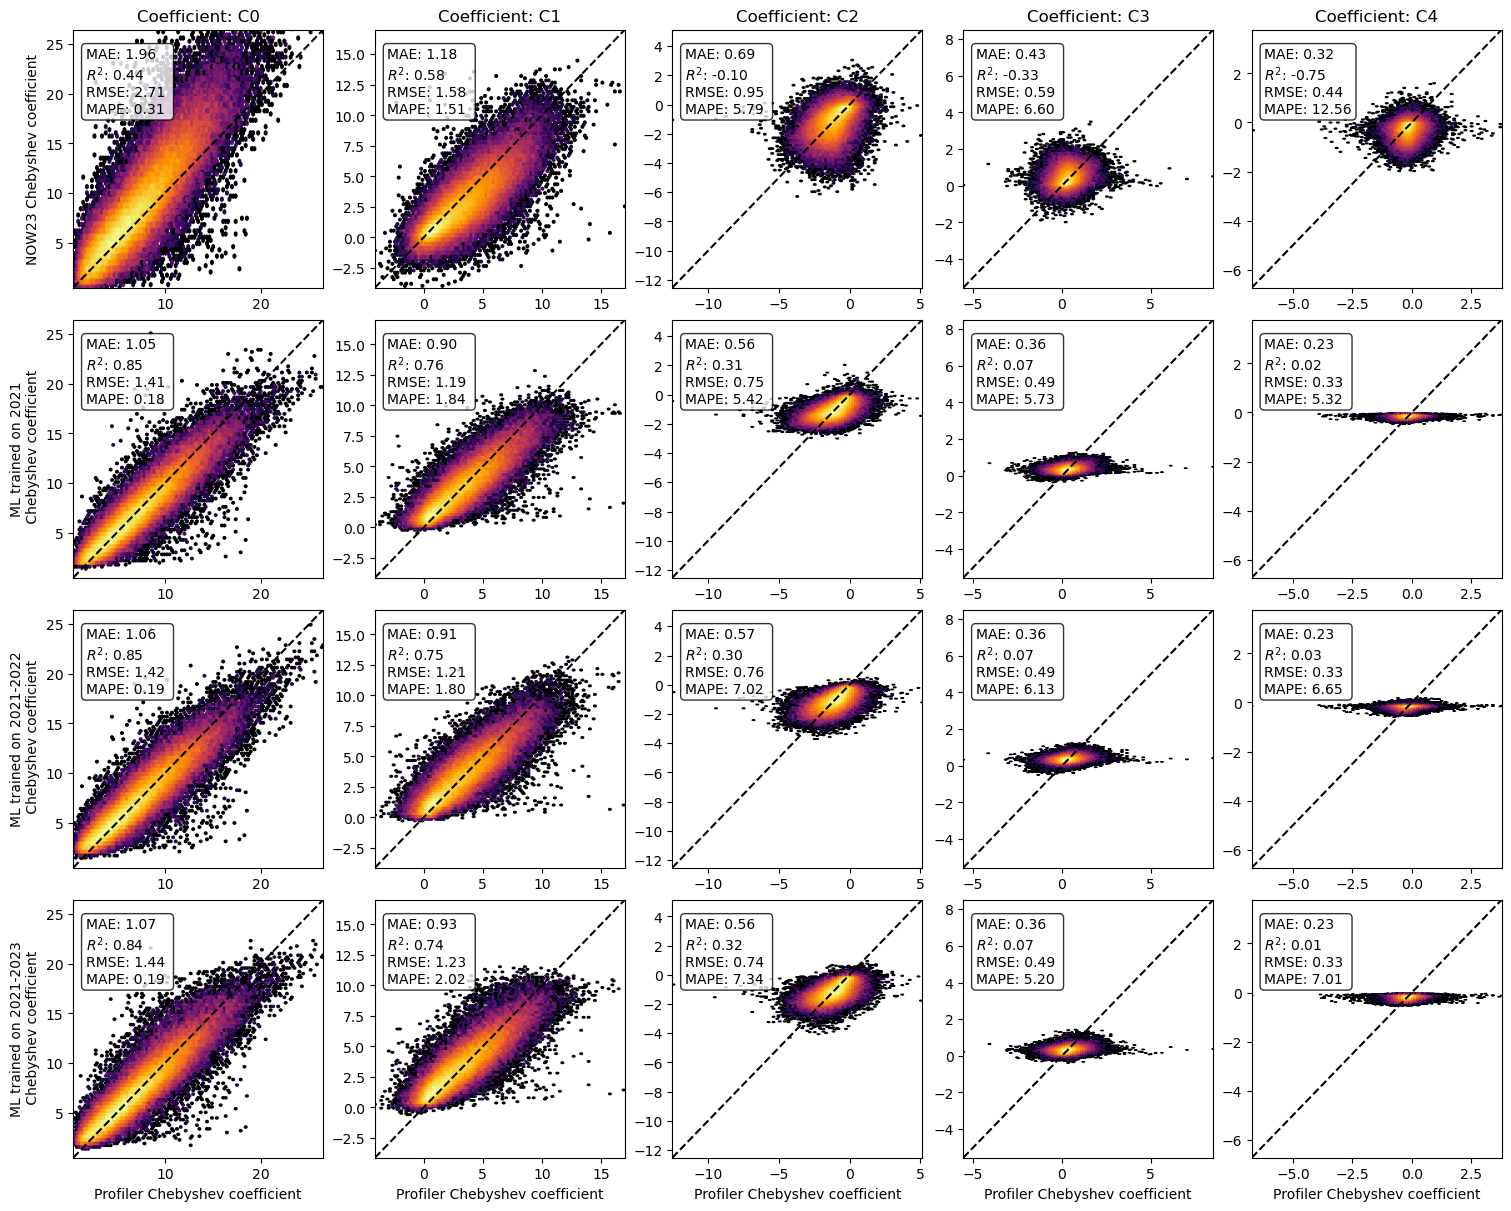

In [6]:
Ens = 9
fig = plt.figure(figsize=(15, 12), constrained_layout=True)
gs = fig.add_gridspec(4,5)
row = 0
for coeff in range(5):
    col = coeff
    ylabel = f'NOW23 Chebyshev coefficient' if col == 0 else ''
    xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
    title = f'Coefficient: C{coeff}' if row == 0 else ''
    hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                NOW23_data.sel(coeff=coeff),
                title,text_arg=True, xlabel=xlabel, ylabel=ylabel)

# --- loading the model with only 2021 year training ---#
row = 1
model_output_dir = f'trained_models/{experiment}/10_stations/{hourly_data_method}/2021/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)

Y_pred = tabReg.predict(X_test)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)

for coeff in range(5):
    col = coeff
    ylabel = f'ML trained on 2021\n Chebyshev coefficient' if col == 0 else ''
    xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
    title = f'Coefficient: C{coeff}' if row == 0 else ''
    hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                Y_pred[:,coeff],
                title,text_arg=True, xlabel=xlabel, ylabel=ylabel)

# --- loading the model with only 2021 and 2022 years training ---#
row = 2
model_output_dir = f'trained_models/{experiment}/10_stations/{hourly_data_method}/2021_to_2022/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)

Y_pred = tabReg.predict(X_test)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)

for coeff in range(5):
    col = coeff
    ylabel = f'ML trained on 2021-2022\n Chebyshev coefficient' if col == 0 else ''
    xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
    title = f'Coefficient: C{coeff}' if row == 0 else ''
    hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                Y_pred[:,coeff],
                title,text_arg=True, xlabel=xlabel, ylabel=ylabel)

# --- loading the model with only 2021, 2022, and 2023 years training ---#
row = 3
model_output_dir = f'trained_models/{experiment}/10_stations/{hourly_data_method}/2021_to_2023/{segregated}/{transformed}/{loss_function}/Ens{Ens}'
fSTR = f'{model_output_dir}/TabNet_HOLDOUT.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)

Y_pred = tabReg.predict(X_test)

if transformed == 'transformed':
    min_max_scaler = joblib.load(f'{model_output_dir}/min_max_scaler.joblib')
    Y_pred = min_max_scaler.inverse_transform(Y_pred)

for coeff in range(5):
    col = coeff
    ylabel = f'ML trained on 2021-2023\n Chebyshev coefficient' if col == 0 else ''
    xlabel = 'Profiler Chebyshev coefficient' if row == 3 else ''
    title = f'Coefficient: C{coeff}' if row == 0 else ''
    hexbin_plotter(fig,gs[row,col],profiler_data.sel(coeff=coeff),
                Y_pred[:,coeff],
                title,text_arg=True, xlabel=xlabel, ylabel=ylabel)

# save the figure
plt.savefig(f'data/Figures/Comparison_bw_profiler_NOW23_ML_temporal_generalization.png')